### INSTALL VIRTUAL ENV & DEPENDENCIES

* Create a python env for the segmentation training call in .venv and add all the required dependencies.

* ``` pip install torch torchvision matplotlib segmentation-models-pytorch opencv-python ```

* segmentation-models-pytorch gives you a U-Net with pretrained backbones (ResNet, EfficientNet, etc.) — much faster convergence than training from scratch.

### INITIAL IMPORTS

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import Cityscapes
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import cv2


In [2]:
# Cityscapes 34 classes → 19 classes mapping
ID_2_TRAINID = {
     0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255, 
     7: 0,    # road
     8: 1,    # sidewalk
     9: 255, 10:255,
    11: 2,    # building
    12: 3,    # wall
    13: 4,    # fence
    14:255, 15:255, 16:255,
    17: 5,    # pole
    18:255,
    19: 6,    # traffic light
    20: 7,    # traffic sign
    21: 8,    # vegetation
    22: 9,    # terrain
    23:10,    # sky
    24:11,    # person
    25:12,    # rider
    26:13,    # car
    27:14,    # truck
    28:15,    # bus
    29:16,    # train
    30:17,    # motorcycle
    31:18,    # bicycle
    32:255, 33:255,
}

def encode_mask(mask):
    # mask is a numpy array (H,W) where values ∈ [0..33]
    encoded = np.zeros_like(mask)
    for id, tid in ID_2_TRAINID.items():
        encoded[mask == id] = tid
    return encoded

### DATASET 

* Define Dataset with fixed mapping
* Apply required transformations - image and mask resizing

In [3]:
class Cityscapes19(Dataset):
    def __init__(self, root, split="train"): 
        self.dataset = Cityscapes(
            root,
            split=split,
            mode="fine",
            target_type="semantic",
        )

        self.img_transform = transforms.Compose([
            transforms.Resize((256, 512)),
            transforms.ToTensor(),
        ])

        self.mask_resize = transforms.Resize((256, 512), interpolation=Image.NEAREST)

    def __len__(self): 
        return len(self.dataset) 
        
    def __getitem__(self, idx): 
        img, mask = self.dataset[idx]      # PIL image + mask

        img = self.img_transform(img)      # image → resized tensor
        mask = self.mask_resize(mask)      # resize mask (PIL)
        mask = np.array(mask)              # raw labels [0..33]
        mask = encode_mask(mask)           # remap → 19 classes + 255
        mask = torch.as_tensor(mask, dtype=torch.long)

        return img, mask


### DEFINE MODEL & LOSS FUNC

* U-Net with multi attention , spatial+channel attention
* CrossEntropyLoss loss function

In [ ]:

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.mlp = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.avg_pool(x)
        w = self.mlp(w)
        return x * w


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [B,C,H,W]
        avg_out = torch.mean(x, dim=1, keepdim=True)    # [B,1,H,W]
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # [B,1,H,W]
        cat = torch.cat([avg_out, max_out], dim=1)      # [B,2,H,W]
        w = self.conv(cat)
        w = self.sigmoid(w)
        return x * w


class HybridAttention(nn.Module):
    def __init__(self, channels, reduction=16, sa_kernel=7):
        super().__init__()
        self.ca = ChannelAttention(channels, reduction=reduction)
        self.sa = SpatialAttention(kernel_size=sa_kernel)

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

In [11]:


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, p_dropout=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if p_dropout > 0.0:
            layers.append(nn.Dropout2d(p_dropout))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class MultiScaleFuse(nn.Module):
    def __init__(self, in_ch_list, out_ch):
        super().__init__()
        total_in = sum(in_ch_list)
        self.conv = nn.Sequential(
            nn.Conv2d(total_in, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, feats, target_size):
        # feats: list of tensors
        upsampled = []
        for f in feats:
            if f.shape[2:] != target_size:
                upsampled.append(F.interpolate(f, size=target_size, mode='bilinear', align_corners=False))
            else:
                upsampled.append(f)
        cat = torch.cat(upsampled, dim=1)
        return self.conv(cat)


In [12]:
# ============================================================
# 5. Improved UNet with Hybrid Attention + Multi-scale fusion
# ============================================================

class ImprovedUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=19, base_ch=32, p_dropout=0.1):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, base_ch, p_dropout)
        self.enc2 = DoubleConv(base_ch, base_ch * 2, p_dropout)
        self.enc3 = DoubleConv(base_ch * 2, base_ch * 4, p_dropout)
        self.enc4 = DoubleConv(base_ch * 4, base_ch * 8, p_dropout)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base_ch * 8, base_ch * 16, p_dropout)

        # Attention modules applied on skip connections
        self.att1 = HybridAttention(base_ch, reduction=8)
        self.att2 = HybridAttention(base_ch * 2, reduction=8)
        self.att3 = HybridAttention(base_ch * 4, reduction=8)
        self.att4 = HybridAttention(base_ch * 8, reduction=8)

        # Multi-scale fusion modules (we will fuse higher+lower skips when decoding)
        self.fuse_d3 = MultiScaleFuse([base_ch * 16, base_ch * 8], base_ch * 8)
        self.dec4 = DoubleConv(base_ch * 8 + base_ch * 8, base_ch * 8)

        self.fuse_d2 = MultiScaleFuse([base_ch * 8, base_ch * 4], base_ch * 4)
        self.dec3 = DoubleConv(base_ch * 4 + base_ch * 4, base_ch * 4)

        self.fuse_d1 = MultiScaleFuse([base_ch * 4, base_ch * 2], base_ch * 2)
        self.dec2 = DoubleConv(base_ch * 2 + base_ch * 2, base_ch * 2)

        self.dec1 = DoubleConv(base_ch * 2 + base_ch, base_ch)

        # Final 1x1 conv to get class logits
        self.out_conv = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def upsample(self, x, target_feature):
        return F.interpolate(x, size=target_feature.shape[2:], mode='bilinear', align_corners=False)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)  # [B, base, H, W]
        x2 = self.enc2(self.pool(x1))   # [B, 2base, H/2, W/2]
        x3 = self.enc3(self.pool(x2))   # [B, 4base, H/4, W/4]
        x4 = self.enc4(self.pool(x3))   # [B, 8base, H/8, W/8]

        xb = self.bottleneck(self.pool(x4))  # [B, 16base, H/16, W/16]

        # Attention on skips
        s4 = self.att4(x4)
        s3 = self.att3(x3)
        s2 = self.att2(x2)
        s1 = self.att1(x1)

        # Decoder - stage 4 (closest to bottleneck)
        # Fuse bottleneck + x4 (multi-scale fusion)
        target_size = s4.shape[2:]
        fused4 = self.fuse_d3([xb, s4], target_size)
        d4 = torch.cat([fused4, s4], dim=1)
        d4 = self.dec4(d4)  # -> [B, 8base, H/8, W/8]

        # stage 3
        target_size = s3.shape[2:]
        fused3 = self.fuse_d2([d4, s3], target_size)
        d3 = torch.cat([fused3, s3], dim=1)
        d3 = self.dec3(d3)  # -> [B, 4base, H/4, W/4]

        # stage 2
        target_size = s2.shape[2:]
        fused2 = self.fuse_d1([d3, s2], target_size)
        d2 = torch.cat([fused2, s2], dim=1)
        d2 = self.dec2(d2)  # -> [B, 2base, H/2, W/2]

        # stage 1
        d1_up = self.upsample(d2, s1)
        d1 = torch.cat([d1_up, s1], dim=1)
        d1 = self.dec1(d1)  # -> [B, base, H, W]

        out = self.out_conv(d1)
        return out


In [14]:


def dice_loss(pred, target, eps=1e-6):
    # pred: logits [B,C,H,W]
    # target: [B,H,W] with values 0..C-1 (or 255 ignored)
    num_classes = pred.shape[1]
    pred_soft = F.softmax(pred, dim=1)

    # one-hot for target
    target_onehot = F.one_hot(torch.clamp(target, 0, num_classes-1), num_classes)  # [B,H,W,C]
    target_onehot = target_onehot.permute(0,3,1,2).float()  # [B,C,H,W]

    # ignore index 255 mask
    mask = (target != 255).unsqueeze(1).float()  # [B,1,H,W]

    intersection = (pred_soft * target_onehot * mask).sum(dim=(2,3))
    union = (pred_soft + target_onehot) * mask
    union = union.sum(dim=(2,3))

    dice = (2. * intersection + eps) / (union + eps)
    loss = 1. - dice
    return loss.mean()


class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, ignore_index=255):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(ignore_index=ignore_index)
        self.alpha = alpha

    def forward(self, logits, target):
        ce_loss = self.ce(logits, target)
        d_loss = dice_loss(logits, target)
        return self.alpha * ce_loss + (1.0 - self.alpha) * d_loss

In [15]:


CITYSCAPES_PALETTE_19 = np.array([
    (128, 64,128), (244, 35,232), (70, 70, 70), (102,102,156),
    (190,153,153), (153,153,153), (250,170, 30), (220,220,  0),
    (107,142, 35), (152,251,152), (70,130,180), (220, 20, 60),
    (255,  0,  0), (  0,  0,142), (  0,  0, 70), (  0, 60,100),
    (  0, 80,100), (  0,  0,230), (119, 11, 32)
], dtype=np.uint8)


def decode_segmap(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id in range(19):
        rgb[mask == cls_id] = CITYSCAPES_PALETTE_19[cls_id]
    return rgb


def compute_iou(preds, labels, num_classes=19):
    preds = preds.view(-1)
    labels = labels.view(-1)

    valid = labels != 255
    preds = preds[valid]
    labels = labels[valid]

    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls

        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

### DATA LOADERS

* Load the data from the Cityscapes dataset that was downloaded to ../cityscapes

In [5]:
from torch.utils.data import DataLoader

root = "../cityscapes/"  # path to Cityscapes dataset

train_ds = Cityscapes19(root, split="train")
val_ds   = Cityscapes19(root, split="val")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2)


### TRAIN THE MODEL and COMPUTE IOU and LOSS at every Epoch

In [ ]:

root = "../cityscapes/"
num_classes = 19
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model
model = ImprovedUNet(in_channels=3, num_classes=num_classes, base_ch=32, p_dropout=0.1).to(device)

criterion = CombinedLoss(alpha=0.5, ignore_index=255)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_miou = 0.0

epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    iou_list = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, masks).item()

            preds = torch.argmax(outputs, dim=1).cpu()
            iou_list.append(compute_iou(preds, masks.cpu(), num_classes=num_classes))

    val_loss = val_loss / len(val_loader)
    iou_arr = np.array(iou_list)
    class_iou = np.nanmean(iou_arr, axis=0)
    mean_iou = np.nanmean(class_iou)

    print(f"Epoch {epoch+1}/40  TrainLoss: {train_loss:.4f}  ValLoss: {val_loss:.4f}  mIoU: {mean_iou:.4f}")

    # Save best
    if mean_iou > best_miou:
        best_miou = mean_iou
torch.save({
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'epoch': epoch,
    'miou': best_miou
}, 'improved_unet.pth')
print(f"Saved model (mIoU={best_miou:.4f})")



Epoch 1/40  Train Loss: 0.8086  Val Loss: 0.4668  mIoU: 0.2168
Epoch 2/40  Train Loss: 0.3970  Val Loss: 0.3772  mIoU: 0.2445
Epoch 3/40  Train Loss: 0.3134  Val Loss: 0.3301  mIoU: 0.2735
Epoch 4/40  Train Loss: 0.2721  Val Loss: 0.3020  mIoU: 0.2841
Epoch 5/40  Train Loss: 0.2405  Val Loss: 0.2790  mIoU: 0.2879
Epoch 6/40  Train Loss: 0.2177  Val Loss: 0.2940  mIoU: 0.2897
Epoch 7/40  Train Loss: 0.2072  Val Loss: 0.2768  mIoU: 0.3024
Epoch 8/40  Train Loss: 0.1916  Val Loss: 0.2860  mIoU: 0.3025
Epoch 9/40  Train Loss: 0.1812  Val Loss: 0.2888  mIoU: 0.2942
Epoch 10/40  Train Loss: 0.1757  Val Loss: 0.2549  mIoU: 0.3127
Epoch 11/40  Train Loss: 0.1575  Val Loss: 0.2669  mIoU: 0.3146
Epoch 12/40  Train Loss: 0.1475  Val Loss: 0.2625  mIoU: 0.3178
Epoch 13/40  Train Loss: 0.1486  Val Loss: 0.2668  mIoU: 0.3190
Epoch 14/40  Train Loss: 0.1609  Val Loss: 0.2554  mIoU: 0.3258
Epoch 15/40  Train Loss: 0.1365  Val Loss: 0.2676  mIoU: 0.3270
Epoch 16/40  Train Loss: 0.1258  Val Loss: 0.2526

In [7]:
CITYSCAPES_PALETTE_19 = np.array([
    (128, 64,128), (244, 35,232), (70, 70, 70), (102,102,156),
    (190,153,153), (153,153,153), (250,170, 30), (220,220,  0),
    (107,142, 35), (152,251,152), (70,130,180), (220, 20, 60),
    (255,  0,  0), (  0,  0,142), (  0,  0, 70), (  0, 60,100),
    (  0, 80,100), (  0,  0,230), (119, 11, 32)
], dtype=np.uint8)


In [8]:
def decode_segmap(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id in range(19):
        rgb[mask == cls_id] = CITYSCAPES_PALETTE_19[cls_id]
    return rgb


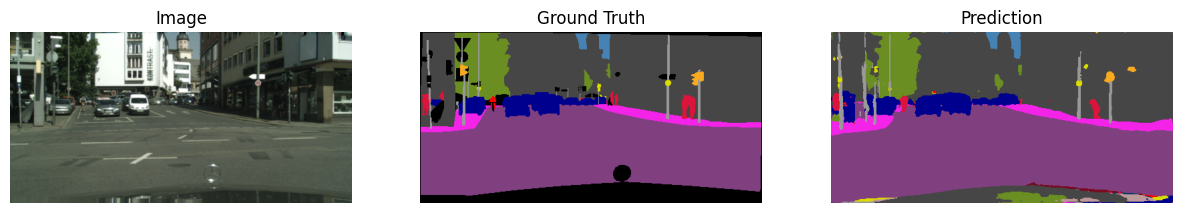

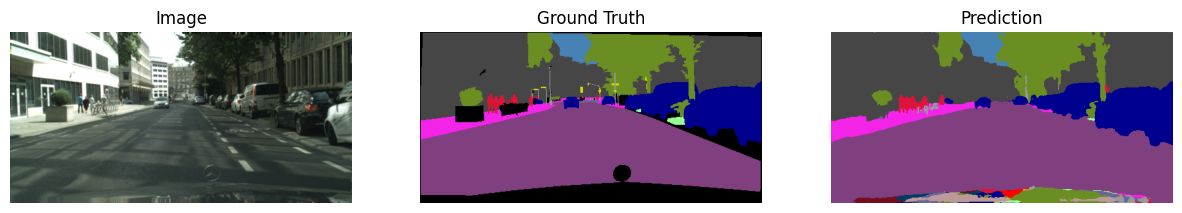

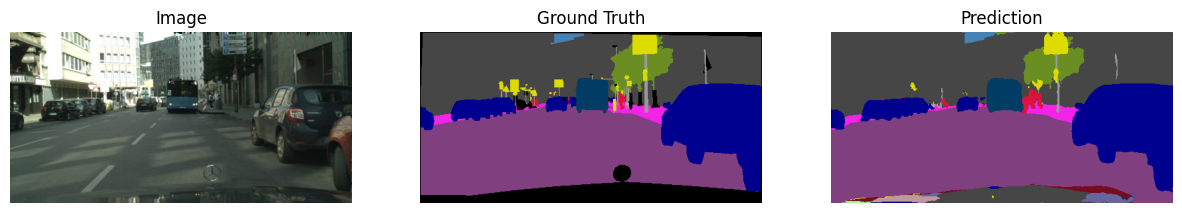

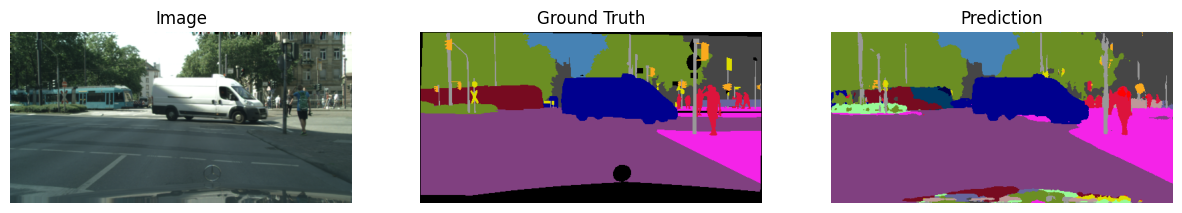

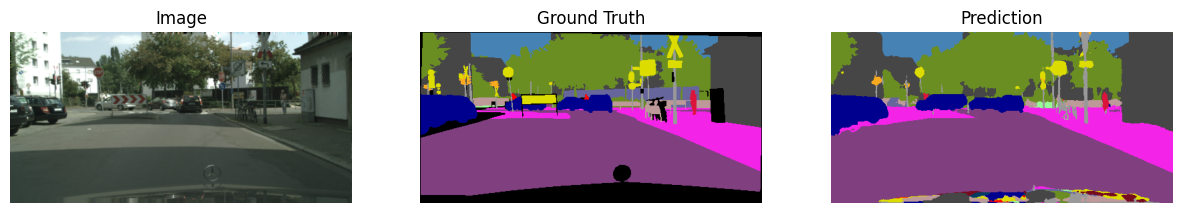

In [18]:
rand = [35,29 ,45, 40, 123]
for i in rand:
    img, mask = val_ds[i]

    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(pred, dim=1).cpu().numpy()[0]

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(decode_segmap(mask.numpy())); plt.title("Ground Truth"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(decode_segmap(pred)); plt.title("Prediction"); plt.axis("off")
    plt.show()


In [23]:
# After training loop ends
save_path = "unet_cityscapes.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to unet_cityscapes.pth


### PROCESS VIDEO: SegInput.mp4 → output.mp4

* Load the trained model
* Process video frame by frame
* Apply segmentation and visualize
* Save as output.mp4


In [24]:
# Load the trained model
# model.load_state_dict(torch.load("unet_cityscapes.pth", map_location=device))
# model.eval()
# print("Model loaded for inference!")

# Video processing setup
input_video = "SegInput.mp4"
output_video = "output.mp4"

cap = cv2.VideoCapture(input_video)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video: {input_video}")

fps = int(cap.get(cv2.CAP_PROP_FPS))
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Input video: {W}x{H} @ {fps} fps, {total_frames} frames")


Input video: 2048x1024 @ 30 fps, 1100 frames


In [25]:

# Preprocessing (matching training: resize + ToTensor, no normalization)
img_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

print("Processing video frames...")
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert BGR to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Convert to PIL Image for transforms
    pil_img = Image.fromarray(rgb_frame)
    
    # Preprocess (resize to 256x512 and convert to tensor)
    img_tensor = img_transform(pil_img).unsqueeze(0).to(device)
    
    # Model inference
    with torch.no_grad():
        outputs = model(img_tensor)
        pred = torch.argmax(outputs, dim=1).cpu().numpy()[0]
    
    # Decode segmentation mask to RGB
    seg_rgb = decode_segmap(pred)
    
    # Resize segmentation mask back to original frame size
    seg_rgb_resized = cv2.resize(seg_rgb, (W, H), interpolation=cv2.INTER_NEAREST)
    
    # Blend original frame with segmentation (overlay)
    # Convert RGB back to BGR for OpenCV
    seg_bgr = cv2.cvtColor(seg_rgb_resized, cv2.COLOR_RGB2BGR)
    blended = cv2.addWeighted(frame, 0.5, seg_bgr, 0.5, 0)
    
    # Write frame to output video
    # out.write(blended)
    image_name = f"frame_{frame_count:06d}.jpg"
    cv2.imwrite(f"blended/{image_name}", blended)
    cv2.imwrite(f"seg/{image_name}", seg_rgb)
    cv2.imwrite(f"seg2/{image_name}", seg_bgr)
    
    frame_count += 1
    if frame_count % 30 == 0:
        print(f"Processed {frame_count}/{total_frames} frames...")

cap.release()
# out.release()
print(f"Video processing complete! Output saved to: {output_video}")

Processing video frames...
Processed 30/1100 frames...
Processed 60/1100 frames...
Processed 90/1100 frames...
Processed 120/1100 frames...
Processed 150/1100 frames...
Processed 180/1100 frames...
Processed 210/1100 frames...
Processed 240/1100 frames...
Processed 270/1100 frames...
Processed 300/1100 frames...
Processed 330/1100 frames...
Processed 360/1100 frames...
Processed 390/1100 frames...
Processed 420/1100 frames...
Processed 450/1100 frames...
Processed 480/1100 frames...
Processed 510/1100 frames...
Processed 540/1100 frames...
Processed 570/1100 frames...
Processed 600/1100 frames...
Processed 630/1100 frames...
Processed 660/1100 frames...
Processed 690/1100 frames...
Processed 720/1100 frames...
Processed 750/1100 frames...
Processed 780/1100 frames...
Processed 810/1100 frames...
Processed 840/1100 frames...
Processed 870/1100 frames...
Processed 900/1100 frames...
Processed 930/1100 frames...
Processed 960/1100 frames...
Processed 990/1100 frames...
Processed 1020/1100